In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [16]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple
from scipy.interpolate import RBFInterpolator
from matplotlib import path
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.tri as tri
from scipy.spatial import distance
import cm_xml_to_matplotlib as make_cmap

import celeri

plt.rcParams["text.usetex"] = False


In [3]:
# Utility functions
n_grid_x = 500
n_grid_y = 500

def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

def rbf_interpolate():
    # Observation coordinates and data
    x_vec = np.linspace(231, 239, n_grid_x)
    y_vec = np.linspace(38, 52, n_grid_y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = RBFInterpolator(xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5)(
        xflat
    )
    ygrid = yflat.reshape(n_grid_x, n_grid_y)
    return xgrid, ygrid

In [4]:
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)


2022-08-31 13:18:00.587 | INFO     | celeri.celeri:get_logger:122 - Read: ../data/command/western_north_america_command.json
2022-08-31 13:18:00.587 | INFO     | celeri.celeri:get_logger:123 - RUN_NAME: 2022-08-31-13-18-00
2022-08-31 13:18:00.587 | INFO     | celeri.celeri:get_logger:124 - Write log file: ../runs/2022-08-31-13-18-00/2022-08-31-13-18-00.log
2022-08-31 13:18:00.588 | INFO     | celeri.celeri:read_data:129 - Reading data files
2022-08-31 13:18:00.593 | SUCCESS  | celeri.celeri:read_data:133 - Read: ../data/segment/western_north_america_segment.csv
2022-08-31 13:18:00.594 | SUCCESS  | celeri.celeri:read_data:138 - Read: ../data/block/western_north_america_block.csv
2022-08-31 13:18:00.595 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2022-08-31 13:18:00.622 | SUCCESS  | celeri.celeri:read_data:265 - Read: ../data/mesh/cascadia.msh
2022-08-31 13:18:00.626 | SUCCESS  | celeri.celeri:read_data:301 - Read: ../data/station/western_north_america_station.csv
2022-08-31 13:18:00.627 | INFO     | celeri.celeri:read_data:316 - No mogi_file_name
2022-08-31 13:18:00.629 | INFO     | celeri.celeri:read_data:338 - No sar_file_name


In [5]:
"""
Estimate the distance between subfaults i and j for every pair in the list
fault.subfaults.

:Inputs:
  -  *fault* of class dtopotools.Fault or some subclass,

:Outputs:
  - *D* array of Euclidean distances based on longitudes, latitudes, and depths
  - *Dstrike* array of estimated distances along strike direction
  - *Ddip* array of estimated distances along dip direction
with D**2 = Dstrike**2 + Ddip**2 to within roundoff.
  """


rad = np.pi / 180.0  # conversion factor from degrees to radians
rr = 6.378e6  # radius of earth
lat2meter = rr * rad  # conversion factor from degrees latitude to meters

nsubfaults = meshes[0].n_tde
D = np.zeros((nsubfaults, nsubfaults))
Dstrike = np.zeros((nsubfaults, nsubfaults))
Ddip = np.zeros((nsubfaults, nsubfaults))
# for i, si in enumerate(fault.subfaults):
for i in range(nsubfaults):
    xi = meshes[0].centroids[i, 0]
    yi = meshes[0].centroids[i, 1]
    zi = meshes[0].centroids[i, 2]
    # for j, sj in enumerate(fault.subfaults):
    for j in range(nsubfaults):
        xj = meshes[0].centroids[j, 0]
        yj = meshes[0].centroids[j, 1]
        zj = meshes[0].centroids[j, 2]
        dx = abs(xi - xj) * np.cos(0.5 * (yi + yj) * np.pi / 180.0) * lat2meter
        dy = abs(yi - yj) * lat2meter
        dz = abs(zi - zj)

        # Euclidean distance:
        D[i, j] = np.sqrt(dx**2 + dy**2 + dz**2)

        # estimate distance down-dip based on depths:
        dip = 0.5 * (meshes[0].dip[i] + meshes[0].dip[j])
        ddip1 = dz / np.sin(dip * np.pi / 180.0)
        Ddip[i, j] = ddip1
        if Ddip[i, j] > D[i, j]:
            # should not happen...
            if 0:
                print("i,j,dx,dy,dz: ", i, j, dx, dy, dz)
                print("*** Ddip = %s, D = %s" % (Ddip[i, j], D[i, j]))

        # compute distance in strike direction to sum up properly:
        dstrike2 = max(D[i, j] ** 2 - Ddip[i, j] ** 2, 0.0)
        Dstrike[i, j] = np.sqrt(dstrike2)


In [11]:
# Build correlation matrix:
# Gaussian with correlation lengths Lstrike and Ldip:
Lstrike = 400e3
Ldip = 40e3

print("Correlation lengths: Lstrike = %g, Ldip = %g" % (Lstrike, Ldip))
r = np.sqrt((Dstrike / Lstrike) ** 2 + (Ddip / Ldip) ** 2)
C = np.exp(-r)

# Replace with:
# https://stackoverflow.com/questions/71346322/numpy-area-of-triangle-and-equation-of-a-plane-on-which-triangle-lies-on
# lengths = np.array([s.length for s in fault.subfaults])
# widths = np.array([s.width for s in fault.subfaults])
# areas = lengths * widths

# def normal(triangles):
#     # The cross product of two sides is a normal vector
#     return np.cross(
#         triangles[:, 1] - triangles[:, 0], triangles[:, 2] - triangles[:, 0], axis=1
#     )

# def area(triangles):
#     # The norm of the cross product of two sides is twice the area
#     return np.linalg.norm(normal(triangles), axis=1) / 2

# triangles =

areas = np.ones(meshes[0].n_tde)
total_area = sum(areas)
mu = 3e10

Mw_desired = 9.0
Mo_desired = 10.0 ** (1.5 * Mw_desired + 9.05)
mean_slip = Mo_desired / (mu * total_area)
print("mean_slip %g meters required for Mw %s" % (mean_slip, Mw_desired))

# Turn this into a constant vector:
mean_slip = mean_slip * np.ones(meshes[0].n_tde)
alpha = 0.5
sigma_slip = alpha * mean_slip

# Lognormal:
Cov_g = np.log((sigma_slip / mean_slip) * (C * (sigma_slip / mean_slip)).T + 1.0)
mean_slip_g = np.log(mean_slip) - np.diag(Cov_g) / 2.0

# This should be the same:
Cov_g = np.log(alpha**2 * C + 1.0)

# Find eigenvalues, and eigenvector matrix.
# Columns V[:,k] are eigenvectors.
print("Finding eigenmodes from %s by %s matrix C" % (meshes[0].n_tde, meshes[0].n_tde))
lam, V = np.linalg.eig(Cov_g)
eigenvals = np.real(lam)  # imaginary parts should be at rounding level
V = np.real(V)

# # Sort eigenvalues:
i = list(np.argsort(lam))
i.reverse()
lam = lam[i]
V = V[:, i]

print(f"{D.shape=}")
print(f"{Cov_g.shape=}")
print(f"{lam.shape=}")
print(f"{V.shape=}")
print(f"{meshes[0].n_tde=}")



Correlation lengths: Lstrike = 400000, Ldip = 40000
mean_slip 6.42429e+08 meters required for Mw 9.0
Finding eigenmodes from 1841 by 1841 matrix C
D.shape=(1841, 1841)
Cov_g.shape=(1841, 1841)
lam.shape=(1841,)
V.shape=(1841, 1841)
meshes[0].n_tde=1841


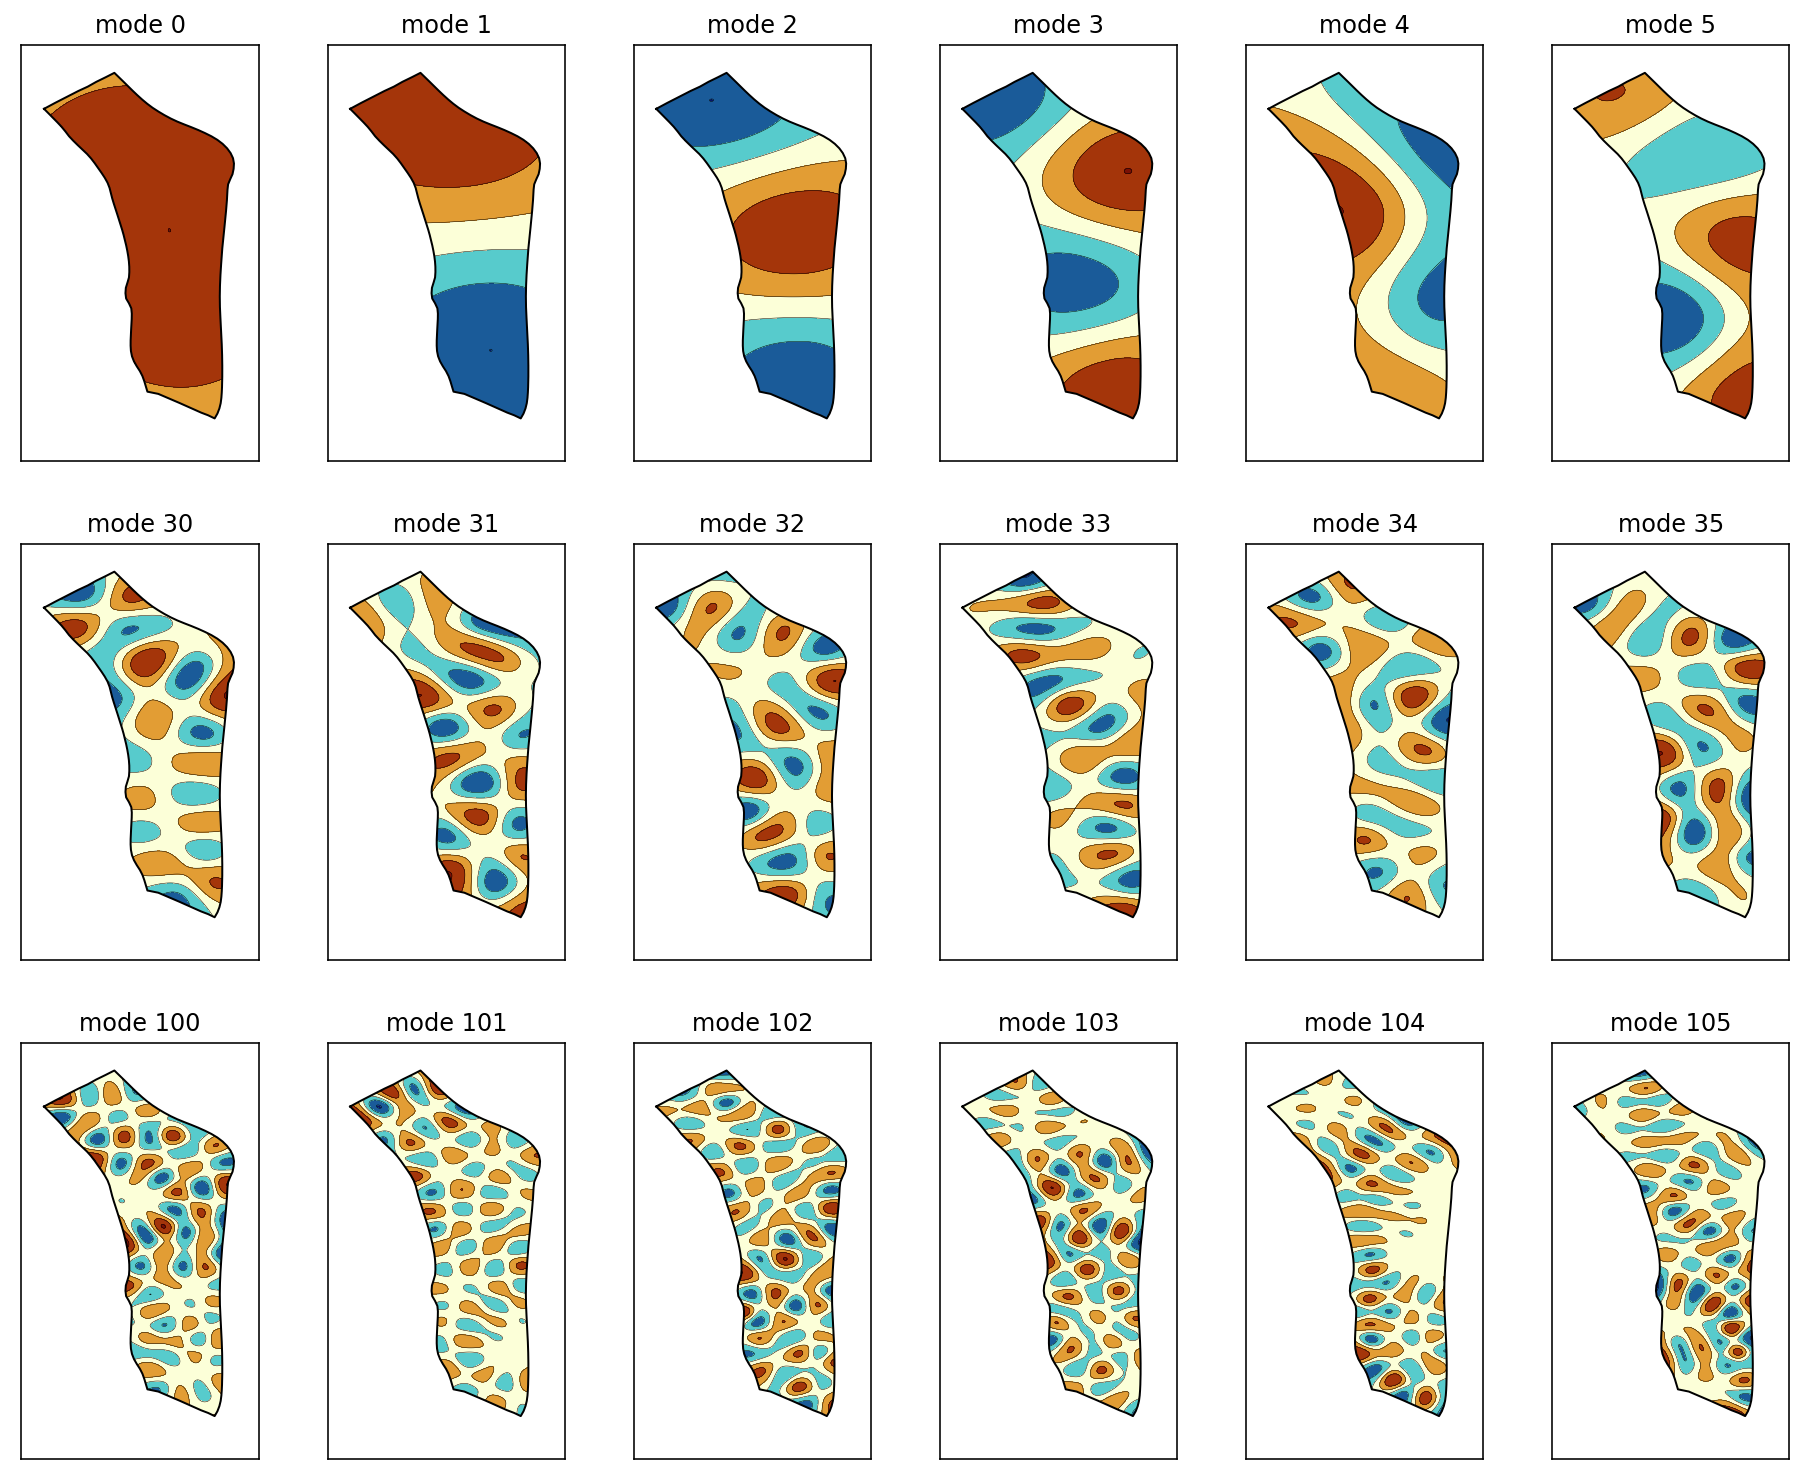

In [7]:
# Plot select eigenmodes
plt.figure(figsize=(16, 13))

cmap = make_cmap.make_cmap("w_ymiddle1.xml")

for i in range(0, 18):
    ax = plt.subplot(3, 6, i + 1)

    # Shift eigenmodes by plotting row to show some dynamic range
    if i > 5 and i <= 11:
        i = i - 6 + 30
    elif i > 11:
        i = i - 12 + 100
    fill_value = fill_value = V[:, i]

    # Normalize fill_value for interpretable plotting
    min_value = np.min(fill_value)
    max_value = np.max(fill_value)
    if np.abs(max_value) > np.abs(min_value):
        fill_value = fill_value / max_value
    else:
        fill_value = fill_value / np.abs(min_value)

    # Interpolate values onto a regular grid for plotting
    xgrid, ygrid = rbf_interpolate()
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, 6)
    plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
    plt.contour(
        *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"mode {i}")

plt.savefig("select_eigenmodes.pdf")
plt.savefig("select_eigenmodes.png", dpi=500)

plt.show()


In [14]:
def get_synthetic_displacements(mesh, tri_linear_operator):
    """
    Prescribe dip-slip in a Gaussian pattern.
    """
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0])
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    # Hardcoded northern Cascadia example that Jack suggested.
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - 234.5
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - 48.5

    # Southern Cascadia example
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0]) - 2
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])


    tri_centroid_to_mesh_centroid_distance = np.sqrt(tri_centroid_to_mesh_lon ** 2 + tri_centroid_to_mesh_lat ** 2)
    dip_slip_distribution = np.exp(-(tri_centroid_to_mesh_centroid_distance / 1.0) ** 2.0)
    slip_distribution = np.zeros(2 * dip_slip_distribution.size)
    slip_distribution[1::2] = dip_slip_distribution # Dip slip only
    slip_distribution[0::2] = 1e-4 * np.random.randn(dip_slip_distribution.size) # Adding a teeny amount of non-zero noise here just so contouring works...ugh
    synthetic_displacements = tri_linear_operator @ slip_distribution
    return slip_distribution, synthetic_displacements

def plot_slip_distributions(mesh, slip_distribution_input, slip_distribution_estimated, suptitle_string):
    triangulation = tri.Triangulation(mesh.centroids[:, 0], mesh.centroids[:, 1])

    levels = np.linspace(-1.0, 1.0, 30)
    vmin = -1.0
    vmax = 1.0
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("input strike-slip")
    tcf = plt.tricontourf(triangulation, slip_distribution_input[0::2], cmap="seismic", levels=levels, vmin=vmin, vmax=vmax, extend="both")
    plt.tricontour(triangulation, slip_distribution_input[0::2], colors="k", linewidths=0.25, levels=levels)
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, color="black", linewidth=1)
    plt.colorbar(tcf)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlim([230.0, 240.0])
    plt.ylim([37.5, 52.5])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 2)
    plt.title("estimated strike-slip")
    tcf = plt.tricontourf(triangulation, slip_distribution_estimated[0::2], cmap="seismic", levels=levels, vmin=vmin, vmax=vmax, extend="both")
    plt.tricontour(triangulation, slip_distribution_estimated[0::2], colors="k", linewidths=0.25, levels=levels)
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, color="black", linewidth=1)
    plt.colorbar(tcf)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlim([230.0, 240.0])
    plt.ylim([37.5, 52.5])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 3)
    plt.title("input dip-slip")
    tcf = plt.tricontourf(triangulation, slip_distribution_input[1::2], cmap="seismic", levels=levels, vmin=vmin, vmax=vmax, extend="both")
    plt.tricontour(triangulation, slip_distribution_input[1::2], colors="k", linewidths=0.25, levels=levels)
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, color="black", linewidth=1)
    plt.colorbar(tcf)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlim([230.0, 240.0])
    plt.ylim([37.5, 52.5])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 4)
    plt.title("estimated dip-slip")
    tcf = plt.tricontourf(triangulation, slip_distribution_estimated[1::2], cmap="seismic", levels=levels, vmin=vmin, vmax=vmax, extend="both")
    plt.tricontour(triangulation, slip_distribution_estimated[1::2], colors="k", linewidths=0.25, levels=levels)
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, color="black", linewidth=1)
    plt.colorbar(tcf)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlim([230.0, 240.0])
    plt.ylim([37.5, 52.5])
    plt.xticks([])
    plt.yticks([])

    plt.suptitle(suptitle_string)
    plt.show()    

In [13]:
operators = addict.Dict()
# operators.tri_station = celeri.get_tri_station_operator_okada(meshes, station, command)
operators.tri_station = celeri.get_tde_to_velocities(meshes, station, command)
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Eliminate matrix entries for vertical displacments and tensile slip
tde_matrix = copy.deepcopy(operators.tri_station)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[0], 3), axis=0)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[1], 3), axis=1)

# Generate Guassian slip source and synthetic displacements
slip_distribution, synthetic_displacements = get_synthetic_displacements(meshes[0], tde_matrix)
slip_distribution_strike_slip_true = slip_distribution[0::2]
slip_distribution_dip_slip_true = slip_distribution[1::2]

Calculating cutde partials for triangles: 100%|██████████| 1841/1841 [00:15<00:00, 118.61it/s]


/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_35279/2130030749.py:36: UserWarning: No contour levels were found within the data range.
  plt.tricontour(triangulation, slip_distribution_input[0::2], colors="k", linewidths=0.25, levels=levels)


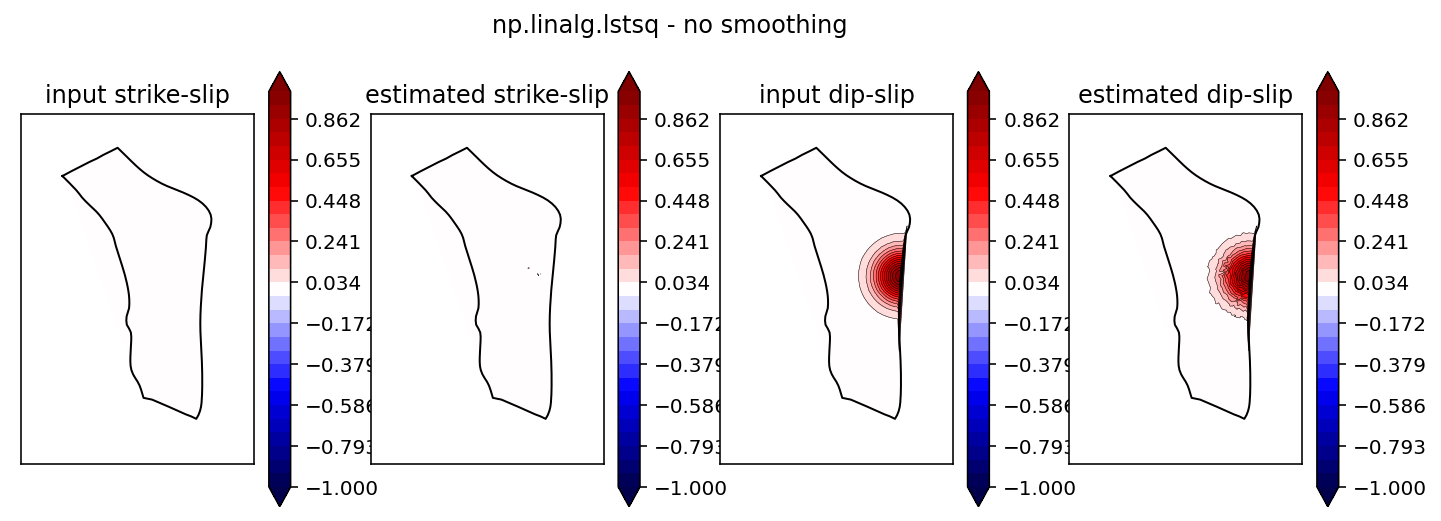

Dip-slip residual = 5.283046455668657


In [27]:
slip_distribution_estimated = np.linalg.lstsq(tde_matrix, synthetic_displacements, rcond=None)
plot_slip_distributions(meshes[0], slip_distribution, slip_distribution_estimated[0], suptitle_string="np.linalg.lstsq - no smoothing")
print("Dip-slip residual = " + str(np.sum(np.abs(slip_distribution_dip_slip_true - slip_distribution_estimated[0][1::2]))))

V.shape=(1841, 1841)
V_small.shape=(1841, 100)
tde_matrix.shape=(3372, 3682)
tde_matrix_dip_only.shape=(3372, 1841)
slip_distribution_eigs.shape=(3682,)


/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_35279/2130030749.py:36: UserWarning: No contour levels were found within the data range.
  plt.tricontour(triangulation, slip_distribution_input[0::2], colors="k", linewidths=0.25, levels=levels)
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_35279/2130030749.py:48: UserWarning: No contour levels were found within the data range.
  plt.tricontour(triangulation, slip_distribution_estimated[0::2], colors="k", linewidths=0.25, levels=levels)


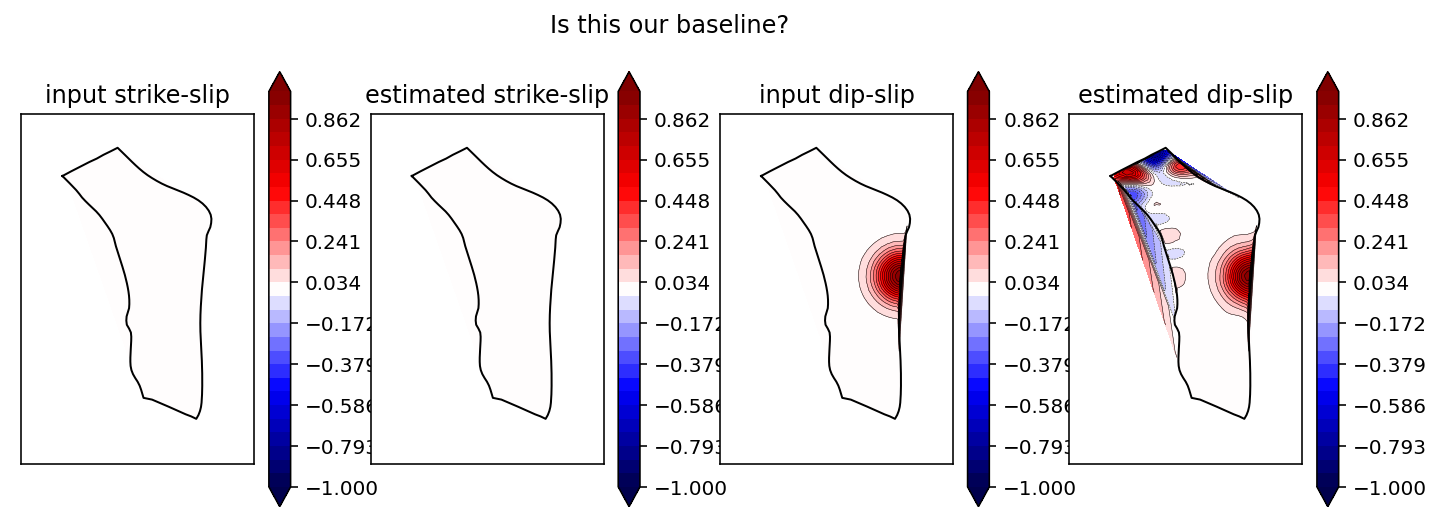

In [79]:
n_eigenvalues = 100
V_small = V[0:n_eigenvalues, :].T
V_small = V[:, 0:n_eigenvalues]

tde_matrix_dip_only = tde_matrix[:, 1::2]

print(f"{V.shape=}")
print(f"{V_small.shape=}")
print(f"{tde_matrix.shape=}")
print(f"{tde_matrix_dip_only.shape=}")
slip_distribution_eigs = np.zeros(2 * V.shape[0])
print(f"{slip_distribution_eigs.shape=}")
eigenvector_weights_estimated = np.linalg.pinv(tde_matrix_dip_only @ V_small) @ synthetic_displacements # Solve for eigenvector weights
slip_distribution_estimated_eigs = V_small @ eigenvector_weights_estimated # Recover slip from eigenvector weights
slip_distribution_eigs[1::2] = slip_distribution_estimated_eigs

plot_slip_distributions(meshes[0], slip_distribution, slip_distribution_eigs, suptitle_string="Is this our baseline?")
# print("Dip-slip residual = " + str(np.sum(np.abs(slip_distribution_dip_slip_true - slip_distribution_estimated[1::2]))))

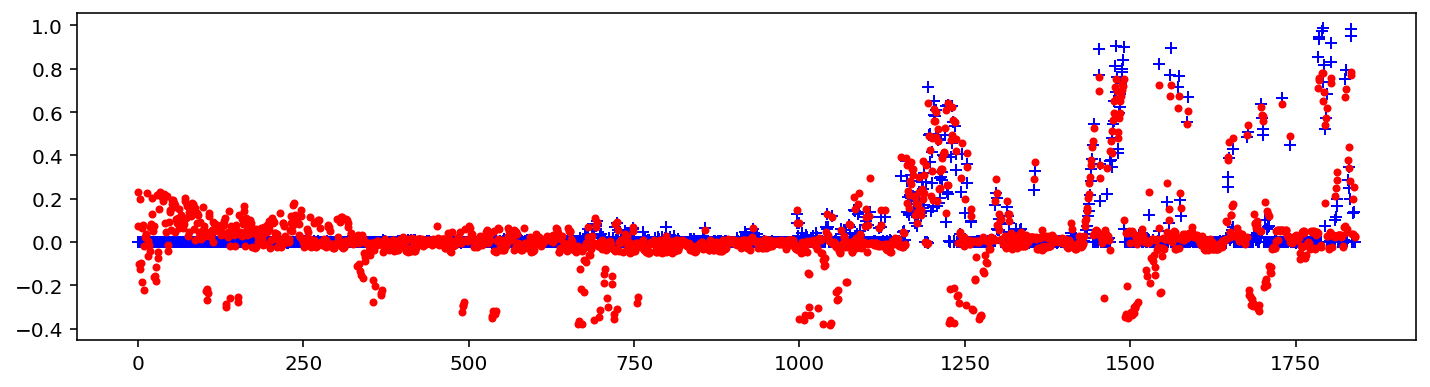

In [78]:
plt.figure(figsize=(12, 3))
plt.plot(slip_distribution_estimated[0][1::2], "b+")
plt.plot(slip_distribution_eigs[1::2], "r.")
plt.show()


In [64]:
print(f"{tde_matrix_dip_only.shape=}")
print(f"{np.squeeze(V_small).shape=}")

(tde_matrix_dip_only @ V_small)

tde_matrix_dip_only.shape=(3372, 1841)
np.squeeze(V_small).shape=(1841, 0)


array([], shape=(3372, 0), dtype=float64)

In [68]:
V_small = V[:, 0:n_eigenvalues]
print(V_small.shape)

(1841, 50)
